In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from decimal import Decimal

def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

In [5]:
with open("times_good.pkl", "rb") as f:
    times = pickle.load(f)

In [6]:
times[0]

{'o': 0.01267099380493164,
 'h': 0.032120704650878906,
 'generation': 0.0005900859832763672,
 'optimal_solution': 24,
 'heuristic_solution': 24.0,
 'multiplier': 3,
 'optimal_n_max': 1,
 'optimal_ls_max': 14,
 'instance': ([ChargingDemand(r=0, d=3, e=24),
   ChargingDemand(r=0, d=3, e=21),
   ChargingDemand(r=0, d=4, e=33)],
  0,
  [0, 1, 2, 3],
  [33, 21, 24])}

In [7]:
# Heuristic iterations

## x = []
## y = []
## z_h = []
## z_o = []
## 
## for p in times:
##     x.append(p["multiplier"])
##     y.append(p["num_chargers"])
##     z_h.append(p["h"])
##     z_o.append(p["o"])
##     # z.append(p["optimal_n_max"] * p["optimal_ls_max"])
## 
## x = np.array(x)
## y = np.array(y)
## z_h = np.array(z_h)
## z_o = np.array(z_o)

In [8]:
## fig = plt.figure(figsize=(10, 8))  # Adjust figure size as needed
## ax = fig.add_subplot(111, projection='3d') # 111 means 1x1 grid, 1st subplot
## 
## scatter_plot = ax.scatter(x, y, z_h, 
##                           marker='o',  # Marker style (e.g., 'o', '^', 's')
##                           s=50,      # Marker size
##                           c='blue',    # Marker color (can be a single color or an array of colors)
##                           alpha=0.7)   # Marker transparency (0 to 1)
## 
## ax.set_xlabel('X-axis Label')
## ax.set_ylabel('Y-axis Label')
## ax.set_zlabel('Z-axis Label')
## ax.set_title('3D Scatter Plot of X, Y, Z')
## 
## plt.show()


In [9]:
# plt.plot(x, np.log(y))

In [10]:
MAX_ITEMS = 6
# plt.plot(x[:MAX_ITEMS], np.log(y)[:MAX_ITEMS])

In [11]:
# x = x[:MAX_ITEMS]
# y= y[:MAX_ITEMS]

In [20]:
def plot_data_with_info(x, y):
    # For plotting the fitted lines smoothly, we'll create a finer x-axis
    x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

    # --- 2. Linear Fit ---
    print("--- Linear Fit ---")
    # Reshape x for scikit-learn
    x_reshaped = x.reshape(-1, 1)

    model_linear = LinearRegression()
    model_linear.fit(x_reshaped, y)
    y_pred_linear = model_linear.predict(x_reshaped)
    mse_linear = mean_squared_error(y, y_pred_linear)
    print(f"MSE (Linear): {format_e(Decimal(mse_linear))}")
    print(f"Equation: y = {model_linear.coef_[0]:.2f}x + {model_linear.intercept_:.2f}\n")

    # For plotting the line
    y_plot_linear = model_linear.predict(x_plot)


    # --- 3. Polynomial Fit ---
    print("--- Polynomial Fit ---")
    degree = 2 # You can change the degree of the polynomial
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_reshaped)

    model_poly = LinearRegression()
    model_poly.fit(x_poly, y)
    y_pred_poly = model_poly.predict(x_poly)
    mse_poly = mean_squared_error(y, y_pred_poly)
    print(f"MSE (Polynomial, degree={degree}): {mse_poly:.4f}")
    # Coefficients: model_poly.coef_ (starts with x^0 if include_bias=True, else x^1)
    # Intercept: model_poly.intercept_
    print(f"Coefficients (from x^0 to x^{degree}): intercept={model_poly.intercept_:.2f}, coefs={np.round(model_poly.coef_[1:], 2) if poly_features.include_bias else np.round(model_poly.coef_,2)}\n")


    # For plotting the curve
    x_plot_poly = poly_features.transform(x_plot)
    y_plot_poly = model_poly.predict(x_plot_poly)


    # --- 4. Exponential Fit (y = a * exp(b*x)) ---
    print("--- Exponential Fit ---")
    # Define the exponential function form
    def exp_func(x_val, a, b):
        return a * np.exp(b * x_val)

    # Perform the curve fit
    # We need to be careful if y contains non-positive values
    positive_y_indices = y > 0
    if not np.all(positive_y_indices):
        print("Warning: Exponential fit works best with y > 0. Fitting on positive y values only.")
        x_exp_fit = x[positive_y_indices]
        y_exp_fit = y[positive_y_indices]
    else:
        x_exp_fit = x
        y_exp_fit = y

    # Provide initial guesses for a and b; can help convergence
    # Guess 'a' as roughly the first y-value and 'b' as small positive
    initial_guess = [y_exp_fit[0] if len(y_exp_fit)>0 else 1, 0.1]
    params_exp, covariance_exp = curve_fit(exp_func, x_exp_fit, y_exp_fit, p0=initial_guess, maxfev=5000)
    a_exp, b_exp = params_exp

    # Predict on the original x values (or all x_plot values)
    y_pred_exp = exp_func(x, a_exp, b_exp)
    mse_exp = mean_squared_error(y, y_pred_exp) # Calculate MSE on all original y
    print(f"MSE (Exponential): {format_e(Decimal(mse_exp))}")
    print(f"Equation: y = {a_exp:.2f} * exp({b_exp:.2f}x)\n")

    # For plotting the curve
    y_plot_exp = exp_func(x_plot.ravel(), a_exp, b_exp)
    exp_fit_successful = True

    # --- 5. Plotting ---
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='black', label='Original Data', zorder=5)

    # Plot Linear Fit
    plt.plot(x_plot, y_plot_linear, color='blue', linestyle='--', label=f'Linear Fit (MSE: {mse_linear:.2f})')

    # Plot Polynomial Fit
    # plt.plot(x_plot, y_plot_poly, color='red', linestyle='-.', label=f'Polynomial Fit (deg {degree}, MSE: {mse_poly:.2f})')

    plt.plot(x_plot, y_plot_exp, color='green', linestyle=':', label=f'Exponential Fit (MSE: {mse_exp:.2f})')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Comparison of Model Fits')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=min(0, y.min() - 0.1 * abs(y.min()))) # Adjust y-axis for better visualization
    plt.show()

    # --- 6. Print MSE Summary ---
    print("\n--- MSE Summary ---")
    print(f"Linear Fit MSE: {mse_linear:.4f}")
    # print(f"Polynomial Fit (degree={degree}) MSE: {mse_poly:.4f}")
    if exp_fit_successful:
        print(f"Exponential Fit MSE: {mse_exp:.4f}")
    else:
        print("Exponential Fit MSE: Not available (fit failed)")

    # Suggest which model is better based on MSE
    mses = {'Linear': mse_linear} #, f'Polynomial (deg {degree})': mse_poly}
    if exp_fit_successful:
        mses['Exponential'] = mse_exp

    if mses: # Check if mses dictionary is not empty
        best_model = min(mses, key=mses.get)
        print(f"\nBased purely on MSE, the '{best_model}' fit seems to be the most similar.")
    else:
        print("\nCould not determine the best model as no fits were successful.")

In [17]:
# plot_data_with_info(x,y)

--- Linear Fit ---
MSE (Linear): 1.287164E+02
Equation: y = 5.45x + -17.91

--- Polynomial Fit ---
MSE (Polynomial, degree=2): 128.6187
Coefficients (from x^0 to x^2): intercept=-14.49, coefs=[4.07 0.13]

--- Exponential Fit ---
MSE (Exponential): 1.321824E+02
Equation: y = 0.82 * exp(0.44x)



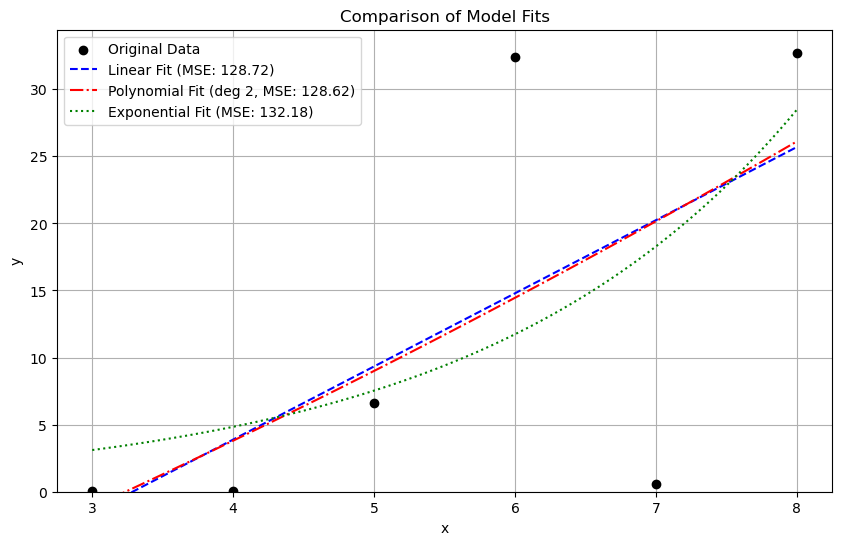


--- MSE Summary ---
Linear Fit MSE: 128.7164
Exponential Fit MSE: 132.1824

Based purely on MSE, the 'Linear' fit seems to be the most similar.


In [18]:
x = []
y = []

for p in times:
    x.append(p["multiplier"])
    y.append(p["h"])

x = np.array(x)[:MAX_ITEMS]
y = np.array(y)[:MAX_ITEMS]

plot_data_with_info(x, y)

--- Linear Fit ---
MSE (Linear): 1.092221E+03
Equation: y = 4.32x + -37.98

--- Polynomial Fit ---
MSE (Polynomial, degree=2): 98.5558
Coefficients (from x^0 to x^2): intercept=23.16, coefs=[-4.89  0.19]

--- Exponential Fit ---
MSE (Exponential): 1.484459E+02
Equation: y = 2.36 * exp(0.09x)



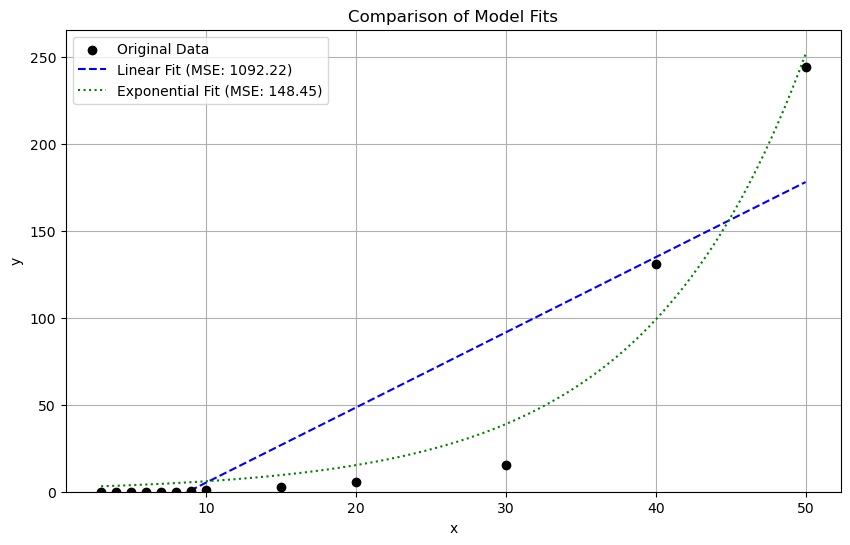


--- MSE Summary ---
Linear Fit MSE: 1092.2213
Exponential Fit MSE: 148.4459

Based purely on MSE, the 'Exponential' fit seems to be the most similar.


In [21]:
x = []
y = []

for p in times:
    x.append(p["multiplier"])
    y.append(p["o"])

x = np.array(x)
y = np.array(y)

plot_data_with_info(x, y)